In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext import vocab

In [2]:
vectors = vocab.Vectors('../../Quora_example/glove.6B.100d.txt','./')

In [3]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import drive
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models
import torch as tensor
from torch.optim import Adam
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification, BertModel
import pandas as pd
from torchtext.legacy.data import Field,BucketIterator,TabularDataset
import re
import torchtext
from Levenshtein import distance as lev
import einops 

In [4]:
# Device configuration

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('device:', device)


device: cuda:0


In [5]:
class CustomTextDataset(Dataset):
    def __init__(self, keywords,b2b_pdesc,neg_anchor,pos_anchor,product_id, y,cont_anchor,cont_label):
        super(Dataset, self).__init__()
        self.y = y
        self.keywords = keywords
        self.b2b_pdesc = b2b_pdesc
        self.neg_anchor = neg_anchor
        self.product_id = product_id
        self.pos_anchor = pos_anchor
        self.cont_anchor = cont_anchor
        self.cont_label = cont_label
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        
        y = self.y[idx]
        keywords = self.keywords[idx]
        b2b_pdesc = self.b2b_pdesc[idx]
        neg_anchor = self.neg_anchor[idx]
        product_id = self.product_id[idx]
        pos_anchor = self.pos_anchor[idx]
        cont_anchor = self.cont_anchor[idx]
        cont_label = self.cont_label[idx]
        sample = {"keywords": keywords, "y": y,
                 'b2b_pdesc':b2b_pdesc,'neg_anchor':neg_anchor,'pos_anchor':pos_anchor,'product_id':product_id,
                  'cont_anchor':cont_anchor,'cont_label':cont_label
                 }
        return sample

In [6]:
vectors.stoi

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9,
 'for': 10,
 '-': 11,
 'that': 12,
 'on': 13,
 'is': 14,
 'was': 15,
 'said': 16,
 'with': 17,
 'he': 18,
 'as': 19,
 'it': 20,
 'by': 21,
 'at': 22,
 '(': 23,
 ')': 24,
 'from': 25,
 'his': 26,
 "''": 27,
 '``': 28,
 'an': 29,
 'be': 30,
 'has': 31,
 'are': 32,
 'have': 33,
 'but': 34,
 'were': 35,
 'not': 36,
 'this': 37,
 'who': 38,
 'they': 39,
 'had': 40,
 'i': 41,
 'which': 42,
 'will': 43,
 'their': 44,
 ':': 45,
 'or': 46,
 'its': 47,
 'one': 48,
 'after': 49,
 'new': 50,
 'been': 51,
 'also': 52,
 'we': 53,
 'would': 54,
 'two': 55,
 'more': 56,
 "'": 57,
 'first': 58,
 'about': 59,
 'up': 60,
 'when': 61,
 'year': 62,
 'there': 63,
 'all': 64,
 '--': 65,
 'out': 66,
 'she': 67,
 'other': 68,
 'people': 69,
 "n't": 70,
 'her': 71,
 'percent': 72,
 'than': 73,
 'over': 74,
 'into': 75,
 'last': 76,
 'some': 77,
 'government': 78,
 'time': 79,
 '$': 80,
 'you': 81,
 'years': 82,
 'i

In [7]:
final_df = pd.read_csv('../../2.TextEmbeddings/MidData/raw_final_hope.csv')
words = list(set((' '.join(final_df['keywords'].astype(str).to_list()+final_df['b2b_pdesc'].astype(str).to_list()+final_df['y'].astype(str).to_list()).split(' '))))
ind_to_word = {i:j for i,j in enumerate(["<unk>"]+words)}
#word_to_ind = {j:i for i,j in enumerate(["<unk>"]+words)}
word_to_ind = vectors.stoi

In [8]:
final_df_cont = final_df.sample(final_df.shape[0],replace=False).reset_index(drop=True)

final_df_cont['cont_anchor'] = final_df_cont.iloc[:int(final_df.shape[0]/2),4].to_list() + final_df_cont.iloc[int(final_df.shape[0]/2):,5].to_list()
final_df_cont['cont_label'] = 1
final_df_cont.iloc[int(final_df.shape[0]/2):,7]=0
final_df = final_df_cont.copy()
del final_df_cont

In [9]:
final_df=final_df.loc[final_df.y.isin(final_df.y.value_counts().reset_index()[:5]['index']),:].reset_index(drop=True)

In [10]:
final_df.y.unique()

array(['tail light', 'fender', 'bumper cover', 'headlight', 'mirror'],
      dtype=object)

In [25]:
def fill_up_(lists_2d):
    list_em_len = [len(i) for i in lists_2d]
    max_len = max(list_em_len)
    return torch.tensor([i + ([0]*(max_len-j)).int if j < max_len else i for i,j in zip(lists_2d,list_em_len) ])


def lookup(texts):
    return [word_to_ind[i] for i in texts.split(' ') if i in word_to_ind.keys()]
    

    
lookup('qwdfq bumper')
    

[14228]

In [12]:
final_df.keywords
final_df.b2b_pdesc
final_df.neg_anchor
final_df.pos_anchor
final_df.product_id
final_df.keywords

0                           passenger tail light
1        front passenger side fender monte carlo
2                          silverado tail lights
3                                     bumper rav
4                               left rear fender
                          ...                   
19975                                  seat belt
19976                       side pasenger fender
19977                                  lihs head
19978                                 mirors for
19979                   mirror side passenger lx
Name: keywords, Length: 19980, dtype: object

In [13]:
from sklearn.model_selection import train_test_split
train,test_mid = train_test_split(final_df,test_size=0.3,stratify=final_df['y'])


valid,test = train_test_split(test_mid,test_size=0.5,stratify=test_mid['y'])

In [14]:
final_df.columns

Index(['keywords', 'y', 'b2b_pdesc', 'product_id', 'neg_anchor', 'pos_anchor',
       'cont_anchor', 'cont_label'],
      dtype='object')

In [15]:
def collate_fn(batch):

    key=torch.tensor(fill_up_([lookup( str(bat['keywords']) ) for bat in batch])).to(device)
    neg = torch.tensor(fill_up_([lookup( str(bat['neg_anchor']) ) for bat in batch])).to(device)
    pos = torch.tensor(fill_up_([lookup( str(bat['pos_anchor']) ) for bat in batch])).to(device)
    cont_anchor = torch.tensor(fill_up_([lookup( str(bat['cont_anchor']) ) for bat in batch])).to(device)
    cont_label = torch.tensor(       [bat['cont_label'] for bat in batch]     ).to(device)
    return [key,pos,neg,cont_anchor,cont_label]

TD_train = CustomTextDataset(keywords = train['keywords'].astype(str).to_list(),
                       b2b_pdesc = train['b2b_pdesc'].astype(str).to_list(),
                       neg_anchor = train['neg_anchor'].astype(str).to_list(),
                       pos_anchor = train['pos_anchor'].astype(str).to_list(),
                       product_id = train['product_id'].astype(str).to_list(),
                       y=train['y'].to_list(),
                             cont_anchor=train['cont_anchor'].to_list(),
                             cont_label=train['cont_label'].to_list()
                            )

TD_test = CustomTextDataset(keywords = test['keywords'].astype(str).to_list(),
                       b2b_pdesc = test['b2b_pdesc'].astype(str).to_list(),
                       neg_anchor = test['neg_anchor'].astype(str).to_list(),
                       pos_anchor = test['pos_anchor'].astype(str).to_list(),
                       product_id = test['product_id'].astype(str).to_list(),
                       y=test['y'].to_list(),
                             cont_anchor=test['cont_anchor'].to_list(),
                             cont_label=test['cont_label'].to_list()
                           )

TD_valid = CustomTextDataset(keywords = valid['keywords'].astype(str).to_list(),
                       b2b_pdesc = valid['b2b_pdesc'].astype(str).to_list(),
                       neg_anchor = valid['neg_anchor'].astype(str).to_list(),
                       pos_anchor = valid['pos_anchor'].astype(str).to_list(),
                       product_id = valid['product_id'].astype(str).to_list(),
                       y=valid['y'].to_list(),
                             cont_anchor=valid['cont_anchor'].to_list(),
                             cont_label=valid['cont_label'].to_list()
                            )


bat_size = 256
DL_DS_train = DataLoader(TD_train, batch_size=bat_size, shuffle=True,collate_fn=collate_fn,drop_last=True)
DL_DS_test = DataLoader(TD_test, batch_size=bat_size, shuffle=True,collate_fn=collate_fn,drop_last=True)
DL_DS_valid = DataLoader(TD_valid, batch_size=bat_size, shuffle=True,collate_fn=collate_fn,drop_last=True)


In [16]:
class LSTMEncoder(torch.nn.Module):
   def __init__(self, output_dim, n_layers=1, vocab_size=None, embedding_dim=None, embeddings=None, bidirectional=False, freeze=True, dropout=0.1):
       super().__init__()
       if embeddings is None:
           self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
       else:
           _, embedding_dim = embeddings.shape
           self.embedding = torch.nn.Embedding.from_pretrained(embeddings=embeddings, padding_idx=0, freeze=freeze)
 
       self.lstm = torch.nn.LSTM(embedding_dim, output_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
       self.directions = 2 if bidirectional else 1
 
       self._projection = torch.nn.Sequential(
           torch.nn.Dropout(dropout),
           torch.nn.Linear(output_dim * self.directions, output_dim),
           torch.nn.BatchNorm1d(output_dim),
           torch.nn.ReLU(),
           torch.nn.Linear(output_dim, output_dim),
           torch.nn.BatchNorm1d(output_dim),
           torch.nn.ReLU(),
           torch.nn.Linear(output_dim, output_dim, bias=False),
       )
 
   def forward(self, x):
       embedded = self.embedding(x) # [batch size, sent len, emb dim]
       output, (hidden, cell) = self.lstm(embedded)
       hidden = einops.rearrange(hidden, '(layer dir) b c -> layer b (dir c)', dir=self.directions)
       return self._projection(hidden[-1])


class SiameseNetwork(torch.nn.Module):
   def __init__(self, learning_rate, transforms, model,margin=1, **kwargs):
       super().__init__()
 
       self.learning_rate = learning_rate
       self.transforms = transforms
       self._encoder = model(**kwargs)
       self.loss = torch.nn.TripletMarginLoss(margin=margin, p=2)#,reducer=0)
 
   def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
 
   def _loss(self, anchor, pos, neg):
       return self.loss(anchor, pos, neg)
 
   def forward(self, anchor, seq1, seq2):
       anchor = self._encoder(anchor)
       emb1 = self._encoder(seq1)
       emb2 = self._encoder(seq2)
       return anchor, emb1, emb2
   def get_embeddings(self, anchor):
       anchor = self._encoder(anchor)
       return anchor

In [17]:
learning_rate = 0.00001 


s_model = SiameseNetwork(learning_rate = learning_rate,transforms = '',margin=5,model=LSTMEncoder,output_dim=300, n_layers=2, vocab_size=len(word_to_ind), embedding_dim=100, embeddings=vectors.vectors, bidirectional=True, freeze=True, dropout=0.1)
s_model.to(device)
optimizer = s_model.configure_optimizers()


epoches = 100
loss_list = []
loss_list_v = []

In [18]:
for epo in range(epoches):
    epo_loss = 0
    epo_loss_test = 0
    for i,batch in enumerate(DL_DS_train):

        s_model.train()
        results = s_model( batch[0], batch[1], batch[2])
        loss=s_model._loss(results[0],results[1],results[2])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epo_loss += loss.item()

    for i,batch in enumerate(DL_DS_test):

        s_model.eval()
        results = s_model( batch[0], batch[1], batch[2])
        loss=s_model._loss(results[0],results[1],results[2])
        epo_loss_test += loss.item()
    loss_list.append(epo_loss/len(DL_DS_train))
    loss_list_v.append(epo_loss_test/len(DL_DS_test))
    print('Train loss : '+str(epo)+ ' '+str(epo_loss/len(DL_DS_train)))
    print('Test loss : '+str(epo)+' '+str(epo_loss_test/len(DL_DS_test)))


C:\Users\Tyler\AppData\Local\Temp/ipykernel_20324/1845132393.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key=torch.tensor(fill_up_([lookup( str(bat['keywords']) ) for bat in batch])).to(device)
C:\Users\Tyler\AppData\Local\Temp/ipykernel_20324/1845132393.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg = torch.tensor(fill_up_([lookup( str(bat['neg_anchor']) ) for bat in batch])).to(device)
C:\Users\Tyler\AppData\Local\Temp/ipykernel_20324/1845132393.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(fill

Train loss : 0 4.952203662307174
Test loss : 0 5.28695518320257
Train loss : 1 4.869909304159659
Test loss : 1 5.128266334533691
Train loss : 2 4.7477316944687455
Test loss : 2 4.881256840445778
Train loss : 3 4.545762415285464
Test loss : 3 4.932013338262385
Train loss : 4 4.239103458545826
Test loss : 4 4.6718432686545635
Train loss : 5 3.7990018041045577
Test loss : 5 4.421245054765181
Train loss : 6 3.305064492755466
Test loss : 6 4.178096749565818
Train loss : 7 2.7571527119036072
Test loss : 7 4.213140921159224
Train loss : 8 2.2500430698747986
Test loss : 8 4.377483909780329
Train loss : 9 1.7936058000282005
Test loss : 9 4.660639719529585
Train loss : 10 1.3820459886833474
Test loss : 10 4.5730156248266045
Train loss : 11 1.0170811392642833
Test loss : 11 5.1810455322265625
Train loss : 12 0.725744323598014
Test loss : 12 5.535582022233442
Train loss : 13 0.512105267908838
Test loss : 13 6.0439584038474345
Train loss : 14 0.35317044925910457
Test loss : 14 6.03472865711559
Trai

In [19]:
class SiameseWithContrastive(torch.nn.Module):
    def __init__(self, learning_rate, transforms, model,margin=1, **kwargs):
       super().__init__()

       self.learning_rate = learning_rate
       self.transforms = transforms
       self._encoder = model(**kwargs)
       self.margin = margin
       self.loss = ContrastiveLoss()
    def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def loss_(self, output1, output2, label):
        return self.loss(output1, output2, label)


    def forward(self, anchor, neg_anchor):
       anchor = self._encoder(anchor)
       neg_anchor = self._encoder(neg_anchor)
       return anchor, neg_anchor
    def get_embeddings(self, anchor):
       anchor = self._encoder(anchor)
       return anchor




In [20]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [21]:
learning_rate = 0.00001 

c_model = SiameseWithContrastive(learning_rate = learning_rate,transforms = '',model=LSTMEncoder,output_dim=300, n_layers=2, vocab_size=len(word_to_ind), embedding_dim=300, embeddings=vectors.vectors, bidirectional=True, freeze=True, dropout=0.1)
c_model.to(device)
optimizer = c_model.configure_optimizers()


epoches = 100
loss_listc = []
loss_listc_v = []

for epo in range(epoches):
    epo_loss = 0
    epo_loss_test = 0
    for i,batch in enumerate(DL_DS_train):

        c_model.train()
        results = c_model( batch[0], batch[3])

        
        loss=c_model.loss_(results[0],results[1],batch[4])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epo_loss += loss.item()

    for i,batch in enumerate(DL_DS_test):

        c_model.eval()
        results = c_model( batch[0], batch[3])
        loss=c_model.loss_(results[0],results[1],batch[4])
        epo_loss_test += loss.item()
    loss_listc.append(epo_loss/len(DL_DS_train))
    loss_listc_v.append(epo_loss_test/len(DL_DS_test))

    print('Train loss : '+str(epo)+ ' '+str(epo_loss/len(DL_DS_train)))
    print('Test loss : '+str(epo)+' '+str(epo_loss_test/len(DL_DS_test)))


C:\Users\Tyler\AppData\Local\Temp/ipykernel_20324/1845132393.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key=torch.tensor(fill_up_([lookup( str(bat['keywords']) ) for bat in batch])).to(device)
C:\Users\Tyler\AppData\Local\Temp/ipykernel_20324/1845132393.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg = torch.tensor(fill_up_([lookup( str(bat['neg_anchor']) ) for bat in batch])).to(device)
C:\Users\Tyler\AppData\Local\Temp/ipykernel_20324/1845132393.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos = torch.tensor(fill

Train loss : 0 32.56881304140444
Test loss : 0 9.629673957824707
Train loss : 1 29.35911538865831
Test loss : 1 10.441589442166416
Train loss : 2 24.824125007346826
Test loss : 2 9.816409717906605
Train loss : 3 19.057314890402335
Test loss : 3 7.947639378634366
Train loss : 4 13.397678675474944
Test loss : 4 5.5667900605635205
Train loss : 5 8.910913467407227
Test loss : 5 3.6046600992029365
Train loss : 6 5.85565349790785
Test loss : 6 2.231438224965876
Train loss : 7 3.9197669559054904
Test loss : 7 1.5558252009478482
Train loss : 8 2.7634928358925714
Test loss : 8 1.223429029638117
Train loss : 9 2.087847133477529
Test loss : 9 1.0972221439534968
Train loss : 10 1.6822537316216364
Test loss : 10 1.0550694248893044
Train loss : 11 1.4622987177636888
Test loss : 11 1.0514497648585925
Train loss : 12 1.3201464745733473
Test loss : 12 1.0616931048306553
Train loss : 13 1.23350351607358
Test loss : 13 1.0681675997647373
Train loss : 14 1.174703143261097
Test loss : 14 1.0818888490850276

In [22]:

valid['keywords_ind'] = [lookup(i) for i in valid.keywords.to_list()]
keywords_list_ind = valid['keywords_ind'].to_list()

In [24]:
keywords_list_ind

[[77833, 14228, 15988],
 [6461, 1063, 437, 248],
 [6461, 46697, 1925, 521, 437, 33499, 36543, 268, 7737],
 [1888, 3825, 4406, 248],
 [669, 437, 62443, 1207],
 [5, 23728, 2603, 897, 218],
 [46697, 20388, 1925, 2790, 5, 437, 17, 62443],
 [5, 14228, 48442],
 [18410, 62443],
 [1925, 177896, 437, 897, 6780],
 [110601, 673, 6780, 897],
 [10, 1925, 437, 6780, 897, 4406],
 [6461, 46697, 1925, 2790, 437, 3513, 6992],
 [669, 17882, 2790, 23728, 46993],
 [2790, 897, 1063, 1393],
 [7255],
 [1393, 2790, 6780, 897, 137],
 [],
 [4512, 362, 16266],
 [897, 362, 10],
 [669, 2218],
 [33222, 62443, 103023],
 [6168, 17, 14228],
 [10, 248, 897, 4406, 9492],
 [62443, 1393, 32669],
 [669, 124418, 23728],
 [6461, 328, 123, 46697, 2790, 5, 437],
 [897, 362],
 [1393, 248, 6780, 897, 4406],
 [],
 [6780, 897],
 [6461, 437],
 [1393, 158455, 6599, 437, 6780, 897, 61439],
 [10, 20530, 532, 9500, 1333, 9348],
 [6780, 897, 4406, 16266],
 [17882, 27189, 81083, 208],
 [669, 14228, 4406, 48442],
 [669, 1333, 6832, 14228, 

In [37]:
c_model.get_embeddings(torch.tensor([[1,2,3]]).cuda().int())

tensor([[-6.4324e-02, -1.0859e-01,  1.3484e-01,  7.8986e-03, -2.2429e-02,
         -1.3015e-01, -3.2405e-03,  1.7406e-01,  1.0807e-02,  1.3753e-02,
         -1.5876e-01, -8.2723e-02,  1.6730e-01,  1.8256e-04, -1.6852e-02,
          2.8189e-02,  4.4081e-02, -2.9112e-02, -3.5219e-02,  1.2829e-02,
          4.6217e-02, -7.2104e-02, -1.6363e-02,  5.5057e-02, -3.9434e-02,
         -1.4151e-01, -5.5328e-02, -9.0507e-02,  1.1112e-01,  5.8085e-02,
          7.6768e-02, -1.9801e-03,  2.5387e-03,  1.4919e-02,  1.6788e-01,
         -1.1114e-02,  3.3304e-03, -1.6255e-01, -1.0494e-01,  7.5370e-02,
          7.7815e-03,  4.0925e-02, -8.9728e-02, -3.1895e-02, -3.0656e-02,
         -1.0658e-01, -8.2921e-02, -7.7502e-02, -7.3245e-02, -1.0103e-02,
         -1.6936e-01,  3.4813e-03,  7.2167e-02, -3.5332e-02, -7.9331e-02,
          4.5530e-02,  7.3465e-02, -1.2440e-01, -5.2479e-02,  9.6018e-04,
         -7.2801e-02,  4.6682e-02,  5.8294e-02, -4.3086e-02, -1.3606e-01,
         -7.3377e-02,  3.8542e-02,  9.

In [38]:
device

device(type='cuda', index=0)

In [54]:
def find_embeddings(lists,models):
    total_list = []
    for i,j in enumerate(lists):
        temp_list = lists.copy()
        models.eval()

        try:
            results = models.get_embeddings(torch.tensor([j]).int().to(device))
            total_list.append(results.tolist()[0])
        except:
            total_list.append(models.get_embeddings(torch.tensor([[0]]).int().to(device))[0])
    return total_list
model_c_keywords_emb = find_embeddings(keywords_list_ind,c_model)
    
    

tensor([[77833, 14228, 15988]], device='cuda:0', dtype=torch.int32)
tensor([[6461, 1063,  437,  248]], device='cuda:0', dtype=torch.int32)
tensor([[ 6461, 46697,  1925,   521,   437, 33499, 36543,   268,  7737]],
       device='cuda:0', dtype=torch.int32)
tensor([[1888, 3825, 4406,  248]], device='cuda:0', dtype=torch.int32)
tensor([[  669,   437, 62443,  1207]], device='cuda:0', dtype=torch.int32)
tensor([[    5, 23728,  2603,   897,   218]], device='cuda:0',
       dtype=torch.int32)
tensor([[46697, 20388,  1925,  2790,     5,   437,    17, 62443]],
       device='cuda:0', dtype=torch.int32)
tensor([[    5, 14228, 48442]], device='cuda:0', dtype=torch.int32)
tensor([[18410, 62443]], device='cuda:0', dtype=torch.int32)
tensor([[  1925, 177896,    437,    897,   6780]], device='cuda:0',
       dtype=torch.int32)
tensor([[110601,    673,   6780,    897]], device='cuda:0', dtype=torch.int32)
tensor([[  10, 1925,  437, 6780,  897, 4406]], device='cuda:0',
       dtype=torch.int32)
tensor(

In [53]:
len(model_c_keywords_emb)

2997

In [55]:
list_keywords_tensor_c = torch.tensor(model_c_keywords_emb).cuda()

In [56]:
list_keywords_tensor_c.shape
list_answer = []
for i,j in enumerate(list_keywords_tensor_c):
    
    index_print = np.argpartition(( j- list_keywords_tensor_c).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    

        
    
    list_answer.append(index_print)
valid['target_y_index'] = list_answer
valid = valid.reset_index(drop=True)
sum(valid.y == valid.y[valid['target_y_index']].reset_index()['y'])/valid.shape[0]

0.7644310977644311

In [69]:

train['keywords_ind'] = [lookup(i) for i in train.keywords.to_list()]
keywords_list_ind_train = train['keywords_ind'].to_list()
def find_embeddings(lists,models):
    total_list = []
    for i,j in enumerate(lists):
        temp_list = lists.copy()
        models.eval()

        try:
            results = models.get_embeddings(torch.tensor([j]).int().to(device))
            total_list.append(results.tolist()[0])
        except:
            total_list.append(models.get_embeddings(torch.tensor([[0]]).int().to(device))[0])
    return total_list
model_c_keywords_emb_train = find_embeddings(keywords_list_ind_train,c_model)
list_keywords_tensor_c_train = torch.tensor(model_c_keywords_emb_train).cuda()
list_keywords_tensor_c_train.shape
list_answer_train = []
for i,j in enumerate(list_keywords_tensor_c_train):
    
    index_print = np.argpartition(( j- list_keywords_tensor_c_train).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    

        
    
    list_answer_train.append(index_print)
train['target_y_index'] = list_answer_train
train = train.reset_index(drop=True)
sum(train.y == train.y[train['target_y_index']].reset_index()['y'])/train.shape[0]

0.8025883025883026

In [70]:
def find_embeddings(lists,models):
    total_list = []
    for i,j in enumerate(lists):
        temp_list = lists.copy()
        models.eval()

        try:
            results = models.get_embeddings(torch.tensor([j]).int().to(device))
            total_list.append(results.tolist()[0])
        except:
            total_list.append(models.get_embeddings(torch.tensor([[0]]).int().to(device))[0])
    return total_list
model_s_keywords_emb_train = find_embeddings(keywords_list_ind_train,s_model)
list_keywords_tensor_s_train = torch.tensor(model_s_keywords_emb_train).cuda()
list_keywords_tensor_s_train.shape
list_answer_train = []
for i,j in enumerate(list_keywords_tensor_s_train):
    
    index_print = np.argpartition(( j- list_keywords_tensor_s_train).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    

        
    
    list_answer_train.append(index_print)
train['target_y_index_s'] = list_answer_train
train = train.reset_index(drop=True)
sum(train.y == train.y[train['target_y_index_s']].reset_index()['y'])/train.shape[0]

0.8037323037323038

In [ ]:
#46.31% - contrastive Loss at 20
#49.28% - Triplet Loss at 20

In [58]:
def find_embeddings(lists,models):
    total_list = []
    for i,j in enumerate(lists):
        temp_list = lists.copy()
        models.eval()
        try:
            results = models.get_embeddings(torch.tensor([j]).int().to(device))
            total_list.append(results.tolist()[0])
        except:
            total_list.append(models.get_embeddings(torch.tensor([[0]]).int().to(device))[0])
    return total_list
model_s_keywords_emb = find_embeddings(keywords_list_ind,s_model)
    
    

In [ ]:

train['keywords_ind'] = [lookup(i) for i in train.keywords.to_list()]
keywords_list_ind_train = train['keywords_ind'].to_list()
def find_embeddings(lists,models):
    total_list = []
    for i,j in enumerate(lists):
        temp_list = lists.copy()
        models.eval()

        try:
            results = models.get_embeddings(torch.tensor([j]).int().to(device))
            total_list.append(results.tolist()[0])
        except:
            total_list.append(models.get_embeddings(torch.tensor([[0]]).int().to(device))[0])
    return total_list
model_c_keywords_emb_train = find_embeddings(keywords_list_ind_train,c_model)
list_keywords_tensor_c_train = torch.tensor(model_c_keywords_emb_train).cuda()
list_keywords_tensor_c_train.shape
list_answer_train = []
for i,j in enumerate(list_keywords_tensor_c_train):
    
    index_print = np.argpartition(( j- list_keywords_tensor_c_train).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    

        
    
    list_answer_train.append(index_print)
train['target_y_index'] = list_answer_train
train = train.reset_index(drop=True)
sum(train.y == train.y[train['target_y_index']].reset_index()['y'])/valid.shape[0]

In [59]:
list_keywords_tensor_s = torch.tensor(model_s_keywords_emb).cuda()

In [60]:
list_keywords_tensor_s.shape
list_answer_s = []
for i,j in enumerate(list_keywords_tensor_s):
    index_print = np.argpartition(( j- list_keywords_tensor_s).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]

    list_answer_s.append(index_print)
valid['target_y_index_s'] = list_answer_s
valid = valid.reset_index(drop=True)
sum(valid.y == valid.y[valid['target_y_index_s']].reset_index()['y'])/valid.shape[0]

0.750417083750417

In [61]:
list_keywords_tensor_c.shape
list_answer3 = []
for i,j in enumerate(list_keywords_tensor_c):
    list_indent_answer = []
    
    
    index_print = np.argpartition(( j- list_keywords_tensor_c).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    list_indent_answer.append(index_print)
    index_print = np.argpartition(( j- list_keywords_tensor_c).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[3]
    list_indent_answer.append(index_print)
    index_print = np.argpartition(( j- list_keywords_tensor_c).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[4]
    list_indent_answer.append(index_print)   
    list_answer3.append(list_indent_answer)
    
valid['target_y_index_3'] = list_answer3
valid = valid.reset_index(drop=True)

#sum(valid.y == valid.y[valid['target_y_index']].reset_index()['y'])/valid.shape[0]

In [62]:

list_answer3_s = []
for i,j in enumerate(list_keywords_tensor_s):
    list_indent_answer = []
    
    
    index_print = np.argpartition(( j- list_keywords_tensor_s).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[2]
    list_indent_answer.append(index_print)
    index_print = np.argpartition(( j- list_keywords_tensor_s).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[3]
    list_indent_answer.append(index_print)
    index_print = np.argpartition(( j- list_keywords_tensor_s).pow(2).sum(1).sqrt().to('cpu'), 2).numpy()[4]
    list_indent_answer.append(index_print)   
    list_answer3_s.append(list_indent_answer)
    
valid['target_y_index_3_s'] = list_answer3_s
valid = valid.reset_index(drop=True)

#sum(valid.y == valid.y[valid['target_y_index']].reset_index()['y'])/valid.shape[0]

In [63]:
valid.loc[valid[['target_y_index_3','y']].apply(lambda x: len([i for i in x.target_y_index_3 if valid['y'][i] == x.y])>0 ,axis=1),:].shape[0]/valid.shape[0]

0.8792125458792125

In [64]:
valid.loc[valid[['target_y_index_3_s','y']].apply(lambda x: len([i for i in x.target_y_index_3_s if valid['y'][i] == x.y])>0 ,axis=1),:].shape[0]/valid.shape[0]

0.8805472138805472

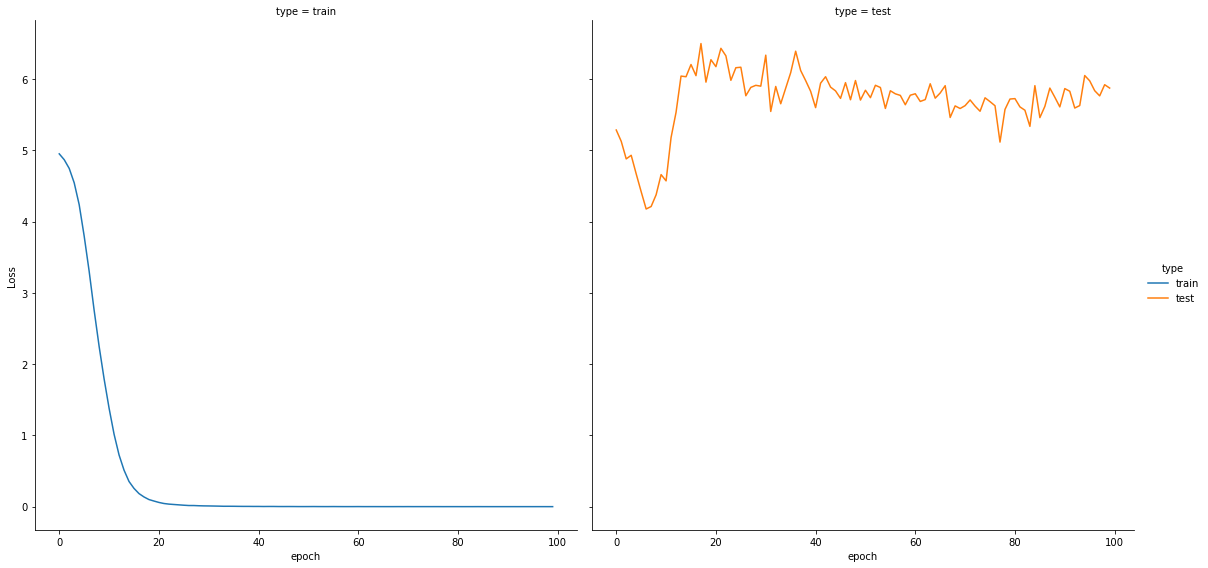

In [67]:
#pd.DataFrame({'':loss_list+loss_list_v})

df_lossgraph = pd.DataFrame({'Loss':(loss_list+[i for i in loss_list_v]),'type':(['train' for i in range(len(loss_list_v))] + ['test' for i in range(len(loss_list_v))]),'epoch':([i for i in range(len(loss_list_v))] + [i for i in range(len(loss_list_v))]) } )



import seaborn as sns
from matplotlib import pyplot as plt

sns.relplot(data = df_lossgraph,x='epoch',y='Loss',col='type',hue='type',kind='line',height=8)



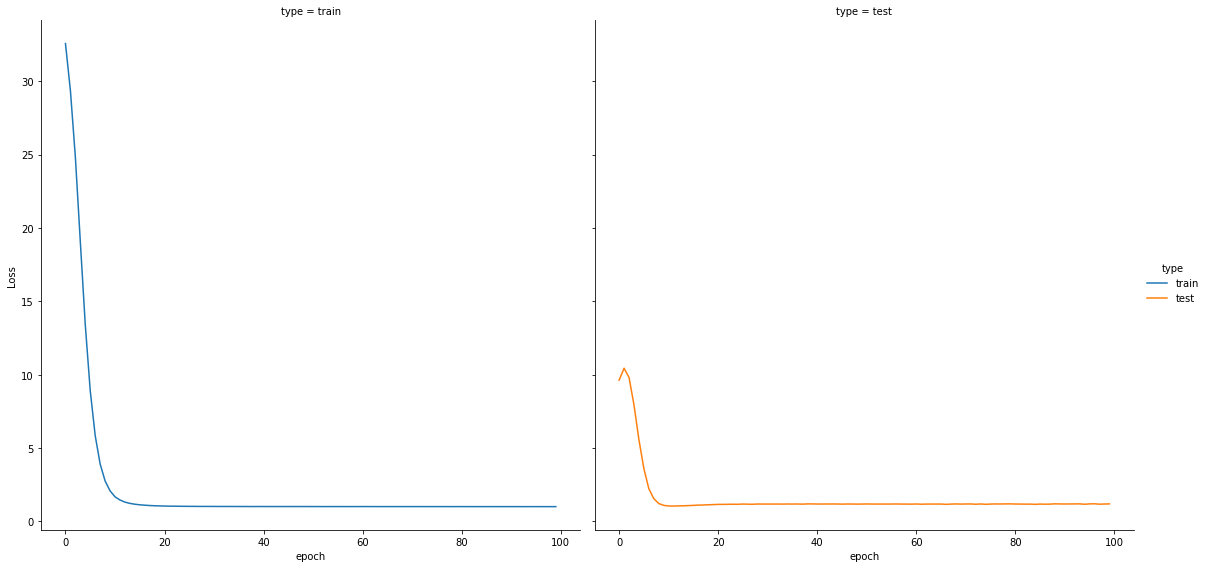

In [66]:
df_lossgraph = pd.DataFrame({'Loss':(loss_listc+[i for i in loss_listc_v]),'type':(['train' for i in range(len(loss_listc_v))] + ['test' for i in range(len(loss_listc_v))]),'epoch':([i for i in range(len(loss_listc_v))] + [i for i in range(len(loss_listc_v))]) } )



import seaborn as sns
from matplotlib import pyplot as plt

sns.relplot(data = df_lossgraph,x='epoch',y='Loss',col='type',hue='type',kind='line',height=8)

In [ ]:
df_lossgraph

In [ ]:
loss_listc_v

In [71]:
c_model

SiameseWithContrastive(
  (_encoder): LSTMEncoder(
    (embedding): Embedding(400000, 100, padding_idx=0)
    (lstm): LSTM(100, 300, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
    (_projection): Sequential(
      (0): Dropout(p=0.1, inplace=False)
      (1): Linear(in_features=600, out_features=300, bias=True)
      (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Linear(in_features=300, out_features=300, bias=True)
      (5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Linear(in_features=300, out_features=300, bias=False)
    )
  )
  (loss): ContrastiveLoss()
)

<AxesSubplot:>

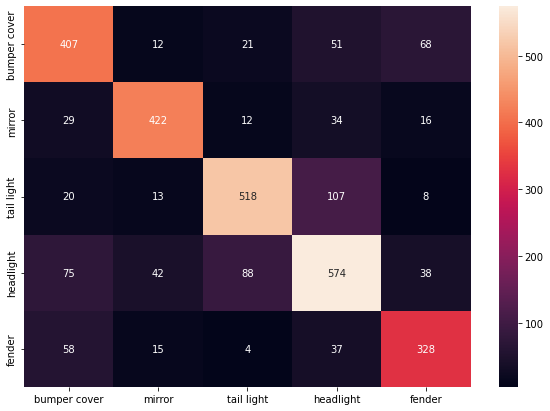

In [85]:
from sklearn.metrics import confusion_matrix
y_true = valid['y']
y_pred = y_true[valid['target_y_index_s']]
confusion_matrix(y_true, y_pred, labels=valid['y'].unique())

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(y_true, y_pred, labels=valid['y'].unique())
df_cm = pd.DataFrame(array, index = [i for i in valid['y'].unique()],
                  columns = [i for i in valid['y'].unique()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt="g")


<AxesSubplot:>

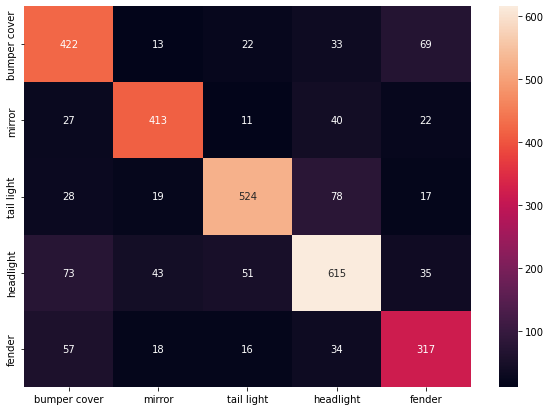

In [84]:
y_true = valid['y']
y_pred = y_true[valid['target_y_index']]
confusion_matrix(y_true, y_pred, labels=valid['y'].unique())

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(y_true, y_pred, labels=valid['y'].unique())
df_cm = pd.DataFrame(array, index = [i for i in valid['y'].unique()],
                  columns = [i for i in valid['y'].unique()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt="g")


In [81]:
valid['y'].unique()

array(['bumper cover', 'mirror', 'tail light', 'headlight', 'fender'],
      dtype=object)

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = 
df_cm = pd.DataFrame(array, index = [i for i in "ABCDEFGHIJK"],
                  columns = [i for i in "ABCDEFGHIJK"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)